<a href="https://colab.research.google.com/github/SOURAVNEAL/Brain-stroke-prediction1/blob/main/MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install matplotlib
!pip install opencv-python
!pip install numpy
!pip install tensorflow

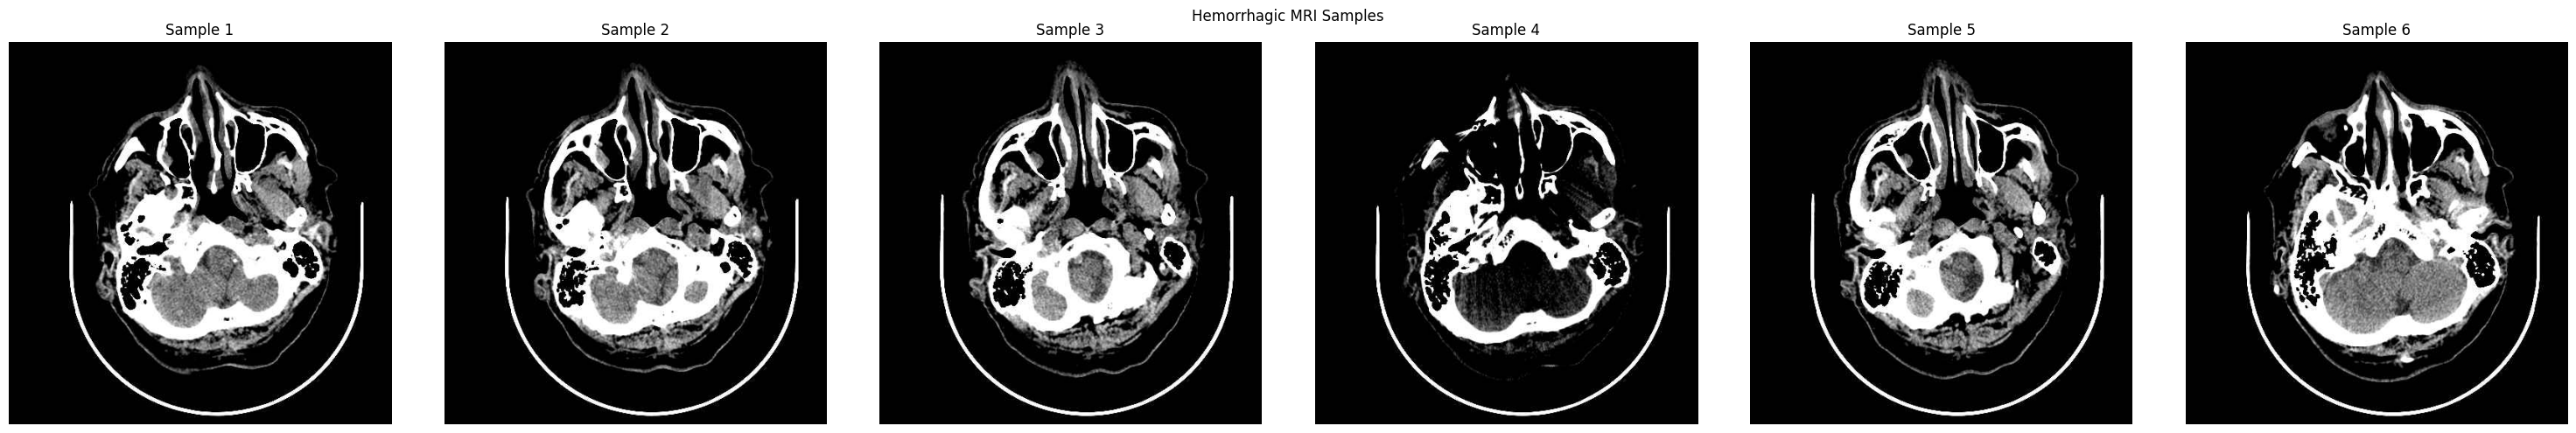

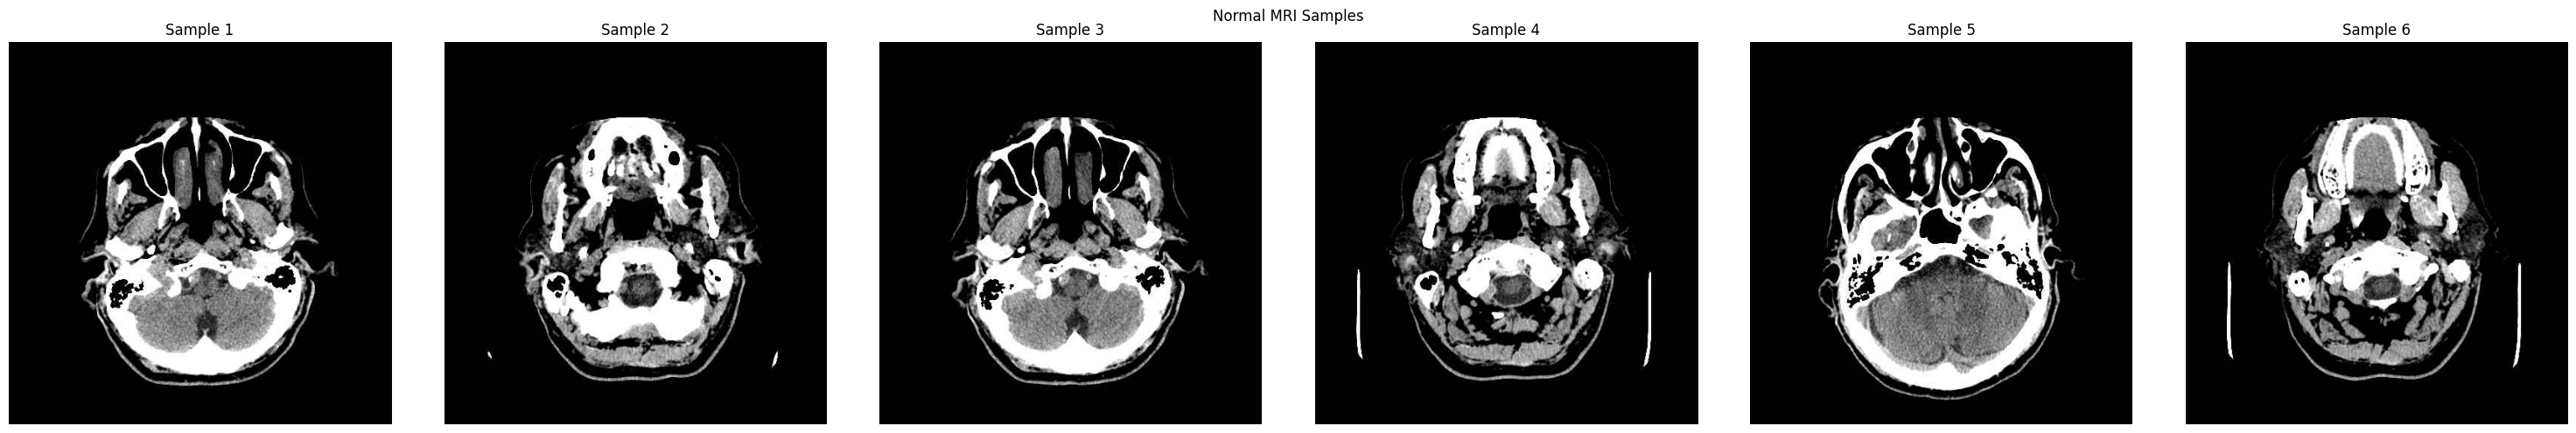

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the directories containing the images
hemorrhagic_dir = "/content/drive/MyDrive/MRI/Data/Hemorrhagic/KANAMA"
normal_dir = "/content/drive/MyDrive/MRI/Data/NORMAL"

# Function to recursively get image files in a directory and its subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                image_files.append(os.path.join(root, file))
    return image_files

# Function to display sample images
def display_sample_images(directory, title, num_images=6):
    image_files = get_image_files(directory)

    if not image_files:
        print(f"No image files found in {directory}")
        return

    # Display the first few images
    num_images_to_display = min(num_images, len(image_files))
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(5 * num_images_to_display, 5))
    fig.suptitle(title)

    for i, img_path in enumerate(image_files[:num_images_to_display]):
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title(f"Sample {i+1}")
        else:
            print(f"Failed to load image: {img_path}")

    plt.tight_layout()
    plt.show()
    fig.savefig("sample_plot.png")

# Display sample images for hemorrhagic MRI
display_sample_images(hemorrhagic_dir, "Hemorrhagic MRI Samples", num_images=6)

# Display sample images for normal MRI
display_sample_images(normal_dir, "Normal MRI Samples", num_images=6)

**Preprocessing using image enhancement**

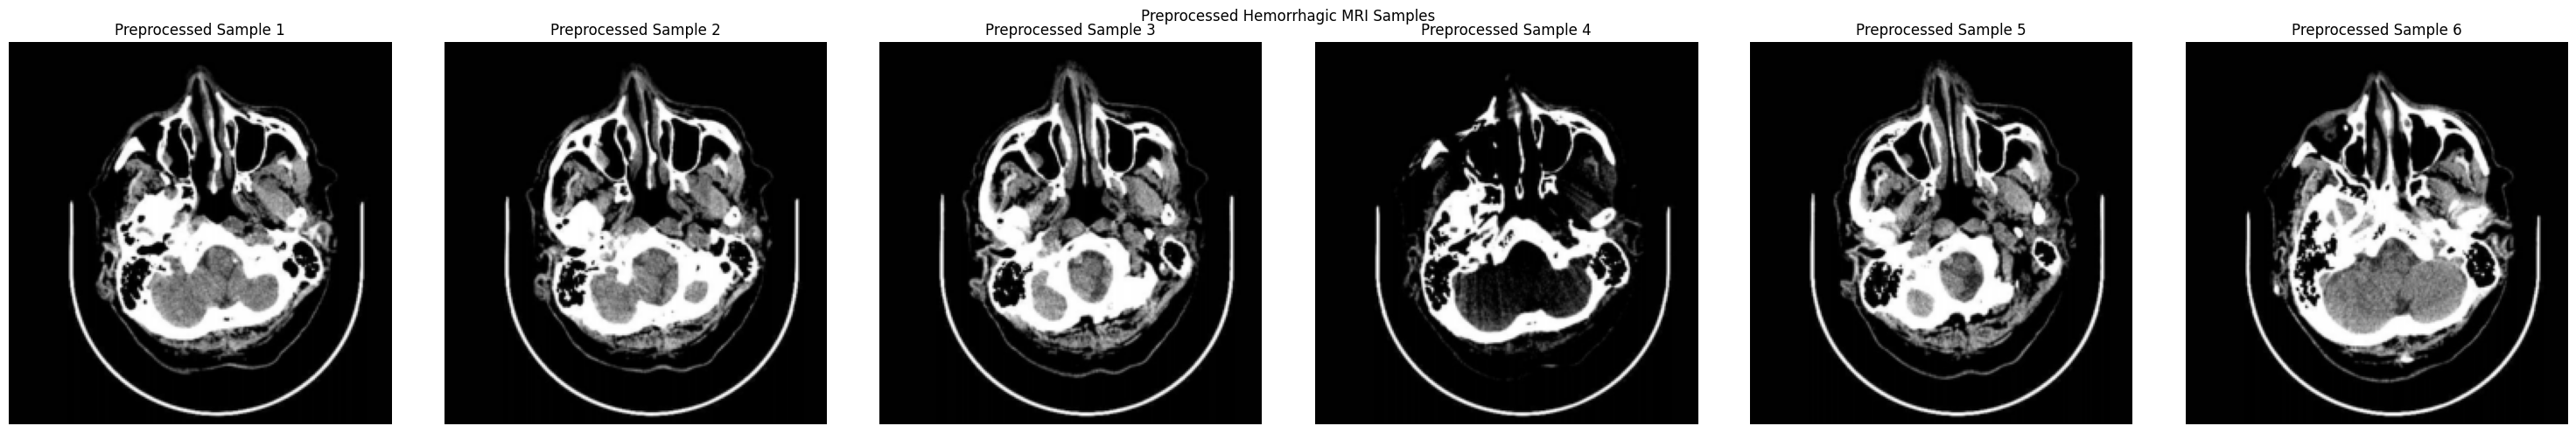

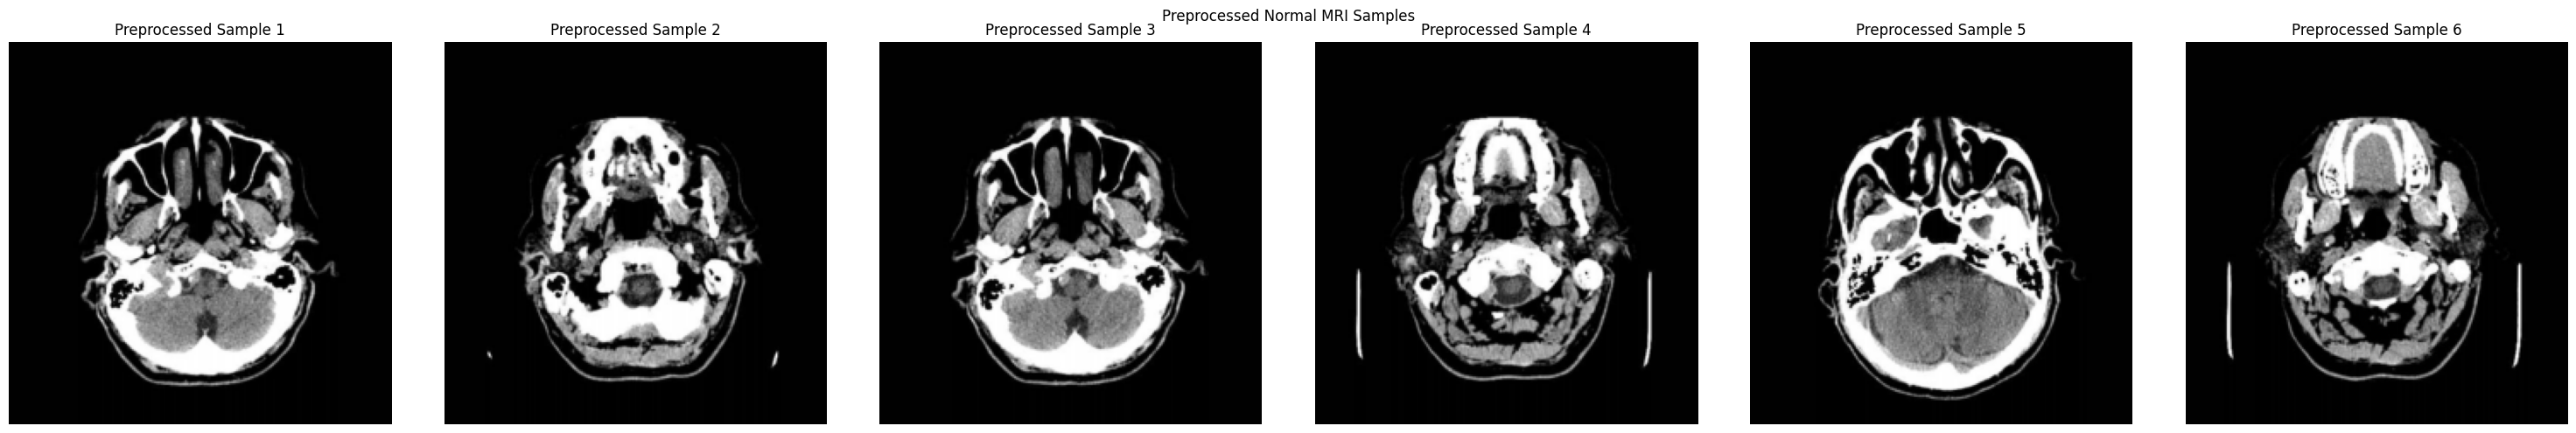

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define the directories containing the images
hemorrhagic_dir = "/content/drive/MyDrive/MRI/Data/Hemorrhagic/KANAMA"
normal_dir = "/content/drive/MyDrive/MRI/Data/NORMAL"

# Function to recursively get image files in a directory and its subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                image_files.append(os.path.join(root, file))
    return image_files

# Preprocessing function
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize the image by dividing by the maximum pixel value to scale between 0 and 1
    img_normalized = img_rgb / 255.0

    # Apply average filter
    averaged_image = cv2.blur(img_normalized, (3, 3))

    # Resize image for deep learning models
    resized_image = cv2.resize(averaged_image, (224, 224))

    # Scale back to [0, 255]
    final_image = (resized_image * 255).astype(np.uint8)

    return final_image

# Function to display sample images after preprocessing
def display_preprocessed_samples(directory, title, num_images=6):
    # Get the list of image files in the directory and its subdirectories
    image_files = get_image_files(directory)

    if not image_files:
        print(f"No image files found in {directory}")
        return

    # Display the first few images after preprocessing
    num_images_to_display = min(num_images, len(image_files))
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(5 * num_images_to_display, 5))
    fig.suptitle(title)

    for i, img_path in enumerate(image_files[:num_images_to_display]):
        img_preprocessed = preprocess_image(img_path)

        if img_preprocessed is not None:
            axs[i].imshow(img_preprocessed)
            axs[i].axis('off')
            axs[i].set_title(f"Preprocessed Sample {i+1}")

    plt.tight_layout()
    plt.show()

# Display preprocessed sample images for hemorrhagic MRI
display_preprocessed_samples(hemorrhagic_dir, "Preprocessed Hemorrhagic MRI Samples", num_images=6)

# Display preprocessed sample images for normal MRI
display_preprocessed_samples(normal_dir, "Preprocessed Normal MRI Samples", num_images=6)

**AlexNet**

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
from torch.utils.data import DataLoader, Dataset
import multiprocessing

# Define the directories containing the images
hemorrhagic_dir = "/content/drive/MyDrive/MRI/Data/Hemorrhagic/KANAMA"
normal_dir = "/content/drive/MyDrive/MRI/Data/NORMAL"

# Function to recursively get image files in a directory and its subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                image_files.append(os.path.join(root, file))
    return image_files

# Custom Dataset for loading images
class MRIDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img_rgb = self.transform(img_rgb)

        return img_rgb

# AlexNet feature extraction class
class AlexNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(AlexNetFeatureExtractor, self).__init__()
        alexnet = models.alexnet(weights='IMAGENET1K_V1')
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            *list(alexnet.classifier.children())[:-1]
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Initialize the AlexNet feature extractor
feature_extractor = AlexNetFeatureExtractor()
feature_extractor.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)

# Define the image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features for all images in a directory using multiprocessing
def extract_features(directory, feature_extractor, transform, batch_size=32):
    image_files = get_image_files(directory)
    dataset = MRIDataset(image_files, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=multiprocessing.cpu_count())

    features = []

    for batch in dataloader:
        batch = batch.to(device)
        with torch.no_grad():
            batch_features = feature_extractor(batch).cpu().numpy()
        features.append(batch_features)

    features = np.vstack(features)
    return features

# Extract features for hemorrhagic MRI
hemorrhagic_features = extract_features(hemorrhagic_dir, feature_extractor, transform)
print(f"Extracted features for hemorrhagic MRI: {hemorrhagic_features.shape[0]} images")

# Extract features for normal MRI
normal_features = extract_features(normal_dir, feature_extractor, transform)
print(f"Extracted features for normal MRI: {normal_features.shape[0]} images")

# Optionally, save the extracted features to a file for later use
np.save('hemorrhagic_features.npy', hemorrhagic_features)
np.save('normal_features.npy', normal_features)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 127MB/s]


Extracted features for hemorrhagic MRI: 49 images
Extracted features for normal MRI: 4121 images


**Linear Projection**

In [ ]:
import numpy as np
import torch
import torch.nn as nn

# Define the linear projection class
class LinearProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProjection, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Assuming you have the extracted features saved as numpy arrays
hemorrhagic_features = np.load('hemorrhagic_features.npy')
normal_features = np.load('normal_features.npy')

# Convert the extracted features to PyTorch tensors
hemorrhagic_tensor = torch.from_numpy(hemorrhagic_features)
normal_tensor = torch.from_numpy(normal_features)

# Define the dimensions for input and output of the linear projection
input_dim = hemorrhagic_tensor.size(1)
output_dim = 128

# Create an instance of the LinearProjection class
linear_projection = LinearProjection(input_dim, output_dim)

# Apply the linear projection to the features
hemorrhagic_projected = linear_projection(hemorrhagic_tensor)
normal_projected = linear_projection(normal_tensor)

# Convert the projected features back to numpy arrays if needed
hemorrhagic_projected_np = hemorrhagic_projected.detach().numpy()
normal_projected_np = normal_projected.detach().numpy()

# Print the shapes of the projected features
print("Projected features shape for hemorrhagic MRI:", hemorrhagic_projected_np.shape)
print("Projected features shape for normal MRI:", normal_projected_np.shape)

Projected features shape for hemorrhagic MRI: (49, 128)
Projected features shape for normal MRI: (4121, 128)


**Self Attention**

In [ ]:
import torch
import torch.nn as nn

# Define the Self-Attention layer
class SelfAttention(nn.Module):
    def __init__(self, input_dim, attention_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.attention_dim = attention_dim

        # Linear layers for keys, queries, and values
        self.key = nn.Linear(input_dim, attention_dim)
        self.query = nn.Linear(input_dim, attention_dim)
        self.value = nn.Linear(input_dim, attention_dim)

        # Scale factor for attention scores
        self.scale = torch.sqrt(torch.FloatTensor([attention_dim])).to(device)

    def forward(self, x):
        batch_size = x.size(0)

        # Linear transformation for keys, queries, and values
        keys = self.key(x).view(batch_size, -1, self.attention_dim)
        queries = self.query(x).view(batch_size, -1, self.attention_dim)
        values = self.value(x).view(batch_size, -1, self.attention_dim)

        # Compute attention scores
        attention_scores = torch.bmm(queries, keys.transpose(1, 2)) / self.scale

        # Apply softmax to get attention weights
        attention_weights = torch.nn.functional.softmax(attention_scores, dim=2)

        # Apply attention to values
        attention_output = torch.bmm(attention_weights, values)

        return attention_output

# Define the dimensions for input and output of the self-attention layer
input_dim = 128
attention_dim = 64

# Create an instance of the SelfAttention class
self_attention = SelfAttention(input_dim, attention_dim)

# Move the self-attention model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
self_attention.to(device)

# Apply self-attention to the projected features
hemorrhagic_attention = self_attention(hemorrhagic_projected)
normal_attention = self_attention(normal_projected)

# Print the shapes of the attention outputs
print("Self-attention output shape for hemorrhagic MRI:", hemorrhagic_attention.shape)
print("Self-attention output shape for normal MRI:", normal_attention.shape)

Self-attention output shape for hemorrhagic MRI: torch.Size([49, 1, 64])
Self-attention output shape for normal MRI: torch.Size([4121, 1, 64])


**Classification Using ML Techniques**

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have the self-attention outputs saved as numpy arrays
hemorrhagic_attention_np = hemorrhagic_attention.detach().numpy().squeeze()
normal_attention_np = normal_attention.detach().numpy().squeeze()

# Combine the features and labels into a single dataset
hemorrhagic_labels = np.ones(len(hemorrhagic_attention_np))
normal_labels = np.zeros(len(normal_attention_np))

X = np.concatenate([hemorrhagic_attention_np, normal_attention_np], axis=0)
y = np.concatenate([hemorrhagic_labels, normal_labels], axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_classifier.fit(X_train, y_train)
mlp_predictions = mlp_classifier.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)

SVM Accuracy: 0.9832134292565947
KNN Accuracy: 0.9940047961630696
MLP Accuracy: 0.9976019184652278


Shape of hemorrhagic_attention_np: (49, 64)
Shape of normal_attention_np: (4121, 64)
Shape of combined feature matrix X: (4170, 64)
Shape of combined labels vector y: (4170,)
Size of X_train: (3336, 64)
Size of X_test: (834, 64)
Size of y_train: (3336,)
Size of y_test: (834,)
Class distribution in training set: {0.0: 3297, 1.0: 39}
Class distribution in testing set: {0.0: 824, 1.0: 10}
Size of X_train_resampled: (6594, 64)
Size of y_train_resampled: (6594,)
Class distribution in resampled training set: {0.0: 3297, 1.0: 3297}
SVM Confusion Matrix:
 [[796  28]
 [  1   9]]
Total samples in SVM Confusion Matrix: 834
KNN Confusion Matrix:
 [[821   3]
 [  1   9]]
Total samples in KNN Confusion Matrix: 834
MLP Confusion Matrix:
 [[821   3]
 [  2   8]]
Total samples in MLP Confusion Matrix: 834


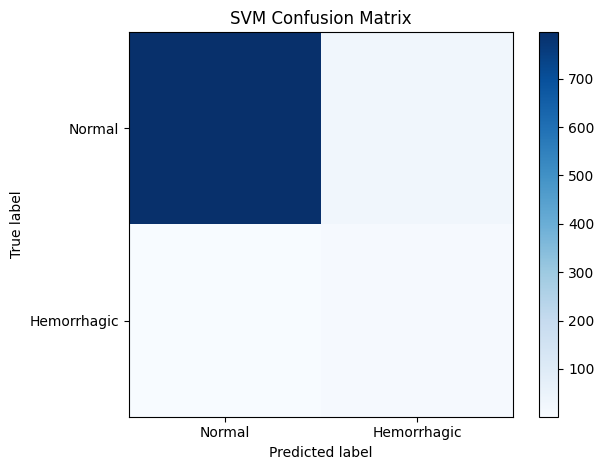

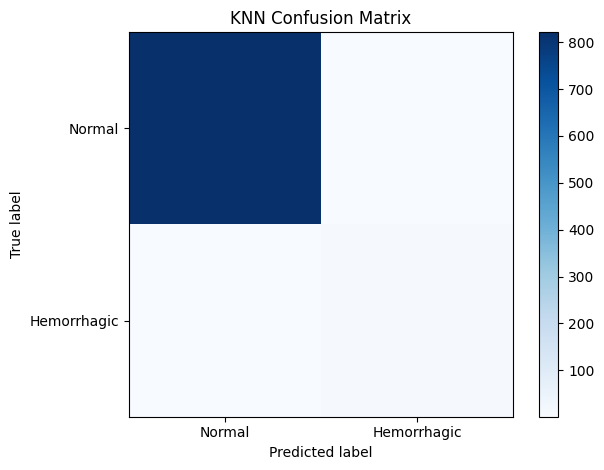

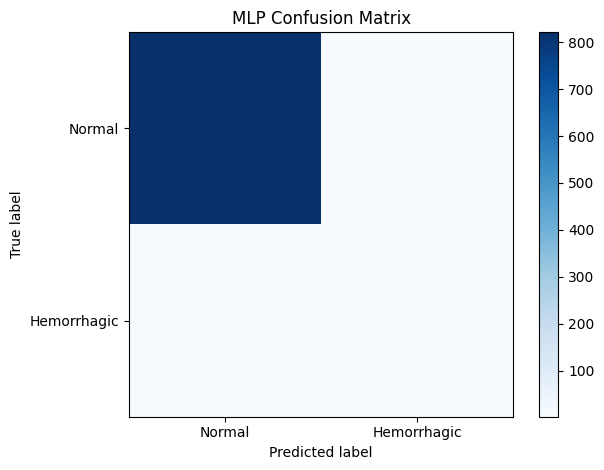

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Assuming hemorrhagic_attention_np and normal_attention_np are already defined

# Verify the shapes of the feature matrices
print("Shape of hemorrhagic_attention_np:", hemorrhagic_attention_np.shape)
print("Shape of normal_attention_np:", normal_attention_np.shape)

# Combine the features and labels into a single dataset
hemorrhagic_labels = np.ones(len(hemorrhagic_attention_np))
normal_labels = np.zeros(len(normal_attention_np))

X = np.concatenate([hemorrhagic_attention_np, normal_attention_np], axis=0)
y = np.concatenate([hemorrhagic_labels, normal_labels], axis=0)

print("Shape of combined feature matrix X:", X.shape)
print("Shape of combined labels vector y:", y.shape)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Size of X_train:", X_train.shape)
print("Size of X_test:", X_test.shape)
print("Size of y_train:", y_train.shape)
print("Size of y_test:", y_test.shape)

# Print class distribution
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Class distribution in {dataset_name} set:", distribution)

print_class_distribution(y_train, "training")
print_class_distribution(y_test, "testing")

# Apply SMOTE to the training data to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Size of X_train_resampled:", X_train_resampled.shape)
print("Size of y_train_resampled:", y_train_resampled.shape)
print_class_distribution(y_train_resampled, "resampled training")

# SVM Classifier
svm_classifier = SVC(kernel='linear', class_weight='balanced')
svm_classifier.fit(X_train_resampled, y_train_resampled)
svm_predictions = svm_classifier.predict(X_test)

# KNN Classifier with weights='distance' (distance-based weighting)
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_classifier.fit(X_train_resampled, y_train_resampled)
knn_predictions = knn_classifier.predict(X_test)

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_classifier.fit(X_train_resampled, y_train_resampled)
mlp_predictions = mlp_classifier.predict(X_test)

# Function to validate confusion matrix size
def validate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total_samples = np.sum(cm)
    return cm, total_samples

# Validate SVM
svm_confusion, svm_total_samples = validate_confusion_matrix(y_test, svm_predictions)
print("SVM Confusion Matrix:\n", svm_confusion)
print("Total samples in SVM Confusion Matrix:", svm_total_samples)

# Validate KNN
knn_confusion, knn_total_samples = validate_confusion_matrix(y_test, knn_predictions)
print("KNN Confusion Matrix:\n", knn_confusion)
print("Total samples in KNN Confusion Matrix:", knn_total_samples)

# Validate MLP
mlp_confusion, mlp_total_samples = validate_confusion_matrix(y_test, mlp_predictions)
print("MLP Confusion Matrix:\n", mlp_confusion)
print("Total samples in MLP Confusion Matrix:", mlp_total_samples)

# Ensure all confusion matrices have the same total number of samples
assert svm_total_samples == len(y_test), "Mismatch in SVM confusion matrix"
assert knn_total_samples == len(y_test), "Mismatch in KNN confusion matrix"
assert mlp_total_samples == len(y_test), "Mismatch in MLP confusion matrix"

# Plotting the Confusion Matrices
class_names = ['Normal', 'Hemorrhagic']

# SVM Confusion Matrix
plt.figure()
plt.imshow(svm_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# KNN Confusion Matrix
plt.figure()
plt.imshow(knn_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# MLP Confusion Matrix
plt.figure()
plt.imshow(mlp_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MLP Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 0: Training loss = 0.6987569254856045, Validation loss = 0.384794682264328
Epoch 10: Training loss = 0.043229538150892234, Validation loss = 0.06735313683748245
Epoch 20: Training loss = 0.03502402972995827, Validation loss = 0.05616934224963188
Epoch 30: Training loss = 0.02847915952466851, Validation loss = 0.04647410288453102
Epoch 40: Training loss = 0.02348655174408629, Validation loss = 0.04021066054701805
Epoch 50: Training loss = 0.01926197024357433, Validation loss = 0.03409242630004883
Epoch 60: Training loss = 0.01655319289805231, Validation loss = 0.032751522958278656
Epoch 70: Training loss = 0.013089553242317222, Validation loss = 0.02959105558693409
Epoch 80: Training loss = 0.010676958642617987, Validation loss = 0.025318507105112076
Epoch 90: Training loss = 0.008665806742648847, Validation loss = 0.021326841786503792


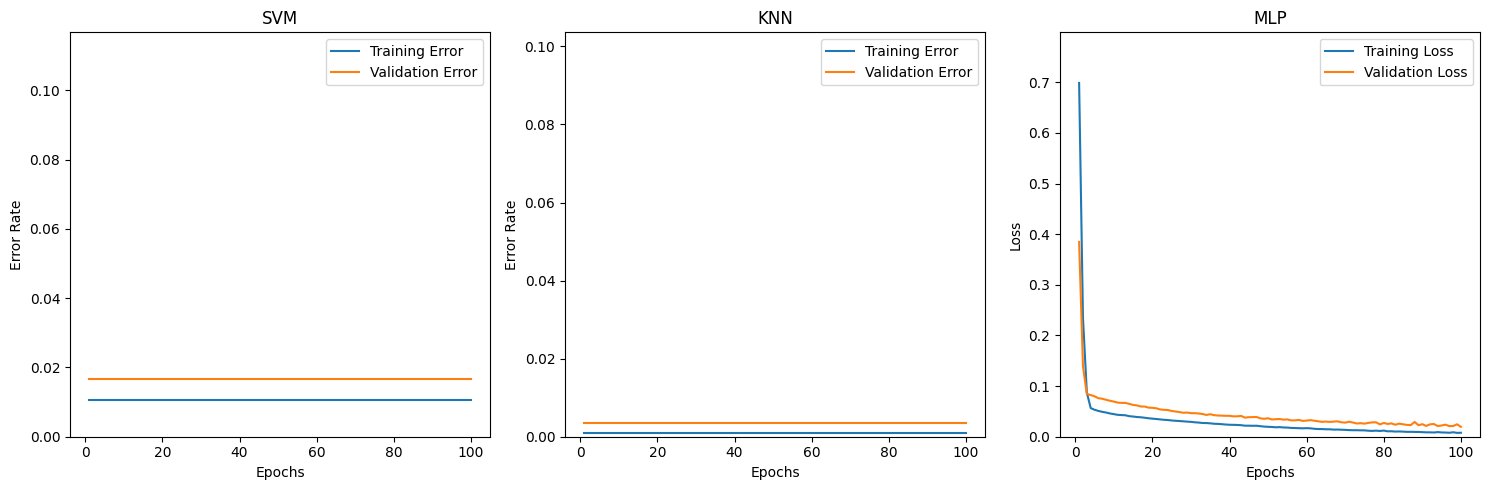

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Combine the features and labels into a single dataset
hemorrhagic_labels = np.ones(len(hemorrhagic_attention_np))
normal_labels = np.zeros(len(normal_attention_np))

X = np.concatenate([hemorrhagic_attention_np, normal_attention_np], axis=0)
y = np.concatenate([hemorrhagic_labels, normal_labels], axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to plot loss curves
def plot_loss_curves(training_loss_svm, validation_loss_svm, training_loss_knn, validation_loss_knn, training_loss_mlp, validation_loss_mlp):
    epochs = range(1, len(training_loss_svm) + 1)

    plt.figure(figsize=(15, 5))

    # SVM subplot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, training_loss_svm, label='Training Error')
    plt.plot(epochs, validation_loss_svm, label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.ylim(0, max(max(training_loss_svm), max(validation_loss_svm)) + 0.1)  # Set y-axis limit
    plt.title('SVM')
    plt.legend()

    # KNN subplot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, training_loss_knn, label='Training Error')
    plt.plot(epochs, validation_loss_knn, label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.ylim(0, max(max(training_loss_knn), max(validation_loss_knn)) + 0.1)  # Set y-axis limit
    plt.title('KNN')
    plt.legend()

    # MLP subplot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, training_loss_mlp, label='Training Loss')
    plt.plot(epochs, validation_loss_mlp, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, max(max(training_loss_mlp), max(validation_loss_mlp)) + 0.1)  # Set y-axis limit
    plt.title('MLP')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Proxy for tracking error rate over epochs
def calculate_error_rate(model, X, y):
    predictions = model.predict(X)
    error_rate = 1 - accuracy_score(y, predictions)
    return error_rate

# Number of epochs for training
n_epochs = 100

# SVM Classifier
svm_classifier = SVC(kernel='linear', probability=True)
training_loss_svm = []
validation_loss_svm = []

# Train SVM incrementally
for epoch in range(n_epochs):
    svm_classifier.fit(X_train, y_train)
    train_error = calculate_error_rate(svm_classifier, X_train, y_train)
    val_error = calculate_error_rate(svm_classifier, X_test, y_test)
    training_loss_svm.append(train_error)
    validation_loss_svm.append(val_error)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
training_loss_knn = []
validation_loss_knn = []

# Train KNN incrementally
for epoch in range(n_epochs):
    knn_classifier.fit(X_train, y_train)
    train_error = calculate_error_rate(knn_classifier, X_train, y_train)
    val_error = calculate_error_rate(knn_classifier, X_test, y_test)
    training_loss_knn.append(train_error)
    validation_loss_knn.append(val_error)

# MLP Classifier with tracking of training and validation loss
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1, warm_start=True)
training_loss_mlp = []
validation_loss_mlp = []

for epoch in range(n_epochs):
    mlp_classifier.fit(X_train, y_train)
    train_loss = mlp_classifier.loss_
    training_loss_mlp.append(train_loss)

    y_val_pred = mlp_classifier.predict_proba(X_test)
    val_loss = -np.mean(np.log(y_val_pred[np.arange(len(y_test)), y_test.astype(int)]))
    validation_loss_mlp.append(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Training loss = {train_loss}, Validation loss = {val_loss}")

# Plot the training and validation loss/error for all models
plot_loss_curves(training_loss_svm, validation_loss_svm, training_loss_knn, validation_loss_knn, training_loss_mlp, validation_loss_mlp)

knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)

**Resnet 50**

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
from torch.utils.data import DataLoader, Dataset
import multiprocessing

# Define the directories containing the images
hemorrhagic_dir = "/content/drive/MyDrive/MRI/Data/Hemorrhagic/KANAMA"
normal_dir = "/content/drive/MyDrive/MRI/Data/NORMAL"

# Function to recursively get image files in a directory and its subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                image_files.append(os.path.join(root, file))
    return image_files

# Custom Dataset for loading images
class MRIDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img_rgb = self.transform(img_rgb)

        return img_rgb

# ResNet-50 feature extraction class
class ResNet50FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet50FeatureExtractor, self).__init__()
        resnet50 = models.resnet50(weights='IMAGENET1K_V1')
        self.features = nn.Sequential(*list(resnet50.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

# Initialize the ResNet-50 feature extractor
feature_extractor = ResNet50FeatureExtractor()
feature_extractor.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)

# Define the image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features for all images in a directory using multiprocessing
def extract_features(directory, feature_extractor, transform, batch_size=32):
    image_files = get_image_files(directory)
    dataset = MRIDataset(image_files, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=multiprocessing.cpu_count())

    features = []

    for batch in dataloader:
        batch = batch.to(device)
        with torch.no_grad():
            batch_features = feature_extractor(batch).cpu().numpy()
        features.append(batch_features)

    features = np.vstack(features)
    return features

# Extract features for hemorrhagic MRI
hemorrhagic_features = extract_features(hemorrhagic_dir, feature_extractor, transform)
print(f"Extracted features for hemorrhagic MRI: {hemorrhagic_features.shape[0]} images")

# Extract features for normal MRI
normal_features = extract_features(normal_dir, feature_extractor, transform)
print(f"Extracted features for normal MRI: {normal_features.shape[0]} images")

# Optionally, save the extracted features to a file for later use
np.save('hemorrhagic_features.npy', hemorrhagic_features)
np.save('normal_features.npy', normal_features)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s]


Extracted features for hemorrhagic MRI: 49 images
Extracted features for normal MRI: 4121 images


**Linear projection**

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Define a linear projection class
class LinearProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProjection, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

# Define the input and output dimensions for the linear projection
input_dim = 2048
output_dim = 128

# Initialize the linear projection layer
linear_projection = LinearProjection(input_dim, output_dim)

# Move the linear projection layer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
linear_projection.to(device)

# Load the extracted features
hemorrhagic_features = np.load('hemorrhagic_features.npy')
normal_features = np.load('normal_features.npy')

# Convert the numpy arrays to PyTorch tensors and move to the appropriate device
hemorrhagic_features_tensor = torch.tensor(hemorrhagic_features, dtype=torch.float32).to(device)
normal_features_tensor = torch.tensor(normal_features, dtype=torch.float32).to(device)

# Apply the linear projection
with torch.no_grad():
    hemorrhagic_projected = linear_projection(hemorrhagic_features_tensor).cpu().numpy()
    normal_projected = linear_projection(normal_features_tensor).cpu().numpy()

# Save the projected features for later use
np.save('hemorrhagic_projected.npy', hemorrhagic_projected)
np.save('normal_projected.npy', normal_projected)

# Print the shapes of the projected features to verify
print(f"Hemorrhagic projected features shape: {hemorrhagic_projected.shape}")
print(f"Normal projected features shape: {normal_projected.shape}")

Hemorrhagic projected features shape: (49, 128)
Normal projected features shape: (4121, 128)


**Self Attention Model**

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Dot product query and keys, scaling by sqrt of the dimension
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) / (self.embed_size ** (1 / 2))

        # Apply softmax to get the weights
        attention = torch.softmax(energy, dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)

        out = self.fc_out(out)
        return out

# Define the Self-Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, embed_size, heads):
        super(AttentionLayer, self).__init__()
        self.self_attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.fc = nn.Linear(embed_size, embed_size)

    def forward(self, x):
        attention = self.self_attention(x, x, x)
        x = self.norm(attention + x)
        forward = self.fc(x)
        out = self.norm(forward + x)
        return out

# Parameters for the self-attention mechanism
embed_size = 128
heads = 8

# Initialize the self-attention layer
attention_layer = AttentionLayer(embed_size, heads)

# Move the attention layer to GPU if available
attention_layer.to(device)

# Load the projected features
hemorrhagic_projected = np.load('hemorrhagic_projected.npy')
normal_projected = np.load('normal_projected.npy')

# Convert the numpy arrays to PyTorch tensors and move to the appropriate device
hemorrhagic_projected_tensor = torch.tensor(hemorrhagic_projected, dtype=torch.float32).to(device)
normal_projected_tensor = torch.tensor(normal_projected, dtype=torch.float32).to(device)

# Reshape the tensors to add batch dimension (assuming each set is a single batch here)
hemorrhagic_projected_tensor = hemorrhagic_projected_tensor.unsqueeze(0)
normal_projected_tensor = normal_projected_tensor.unsqueeze(0)

# Apply the self-attention layer
with torch.no_grad():
    hemorrhagic_attention_output = attention_layer(hemorrhagic_projected_tensor).cpu().numpy()
    normal_attention_output = attention_layer(normal_projected_tensor).cpu().numpy()

# Save the self-attention outputs for later use
np.save('hemorrhagic_attention_output.npy', hemorrhagic_attention_output)
np.save('normal_attention_output.npy', normal_attention_output)

# Print the shapes of the self-attention outputs to verify
print(f"Hemorrhagic attention output shape: {hemorrhagic_attention_output.shape}")
print(f"Normal attention output shape: {normal_attention_output.shape}")

Hemorrhagic attention output shape: (1, 49, 128)
Normal attention output shape: (1, 4121, 128)


**Classification Using ML Techniques**

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Load the self-attention outputs
hemorrhagic_attention_output = np.load('hemorrhagic_attention_output.npy').squeeze()
normal_attention_output = np.load('normal_attention_output.npy').squeeze()

# Combine the features and labels into a single dataset
hemorrhagic_labels = np.ones(len(hemorrhagic_attention_output))
normal_labels = np.zeros(len(normal_attention_output))

X = np.concatenate([hemorrhagic_attention_output, normal_attention_output], axis=0)
y = np.concatenate([hemorrhagic_labels, normal_labels], axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_classifier.fit(X_train, y_train)
mlp_predictions = mlp_classifier.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)

SVM Accuracy: 0.9988009592326139
KNN Accuracy: 0.9964028776978417
MLP Accuracy: 0.9976019184652278


Shape of hemorrhagic_attention_np: (49, 64)
Shape of normal_attention_np: (4121, 64)
Shape of combined feature matrix X: (4170, 64)
Shape of combined labels vector y: (4170,)
Size of X_train: (3336, 64)
Size of X_test: (834, 64)
Size of y_train: (3336,)
Size of y_test: (834,)
Class distribution in training set: {0.0: 3297, 1.0: 39}
Class distribution in testing set: {0.0: 824, 1.0: 10}
Size of X_train_resampled: (6594, 64)
Size of y_train_resampled: (6594,)
Class distribution in resampled training set: {0.0: 3297, 1.0: 3297}
SVM Confusion Matrix:
 [[796  28]
 [  1   9]]
Total samples in SVM Confusion Matrix: 834
KNN Confusion Matrix:
 [[821   3]
 [  1   9]]
Total samples in KNN Confusion Matrix: 834
MLP Confusion Matrix:
 [[821   3]
 [  2   8]]
Total samples in MLP Confusion Matrix: 834


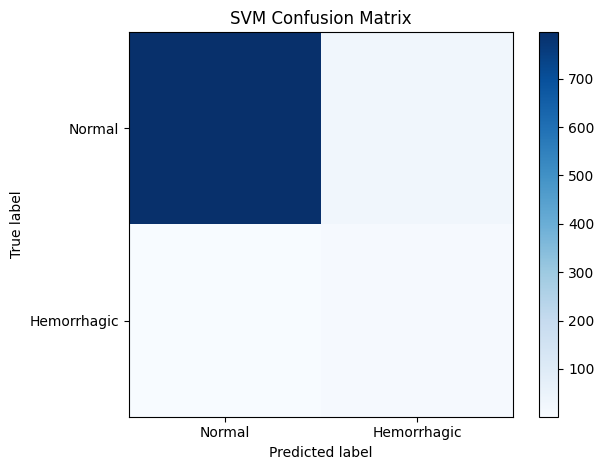

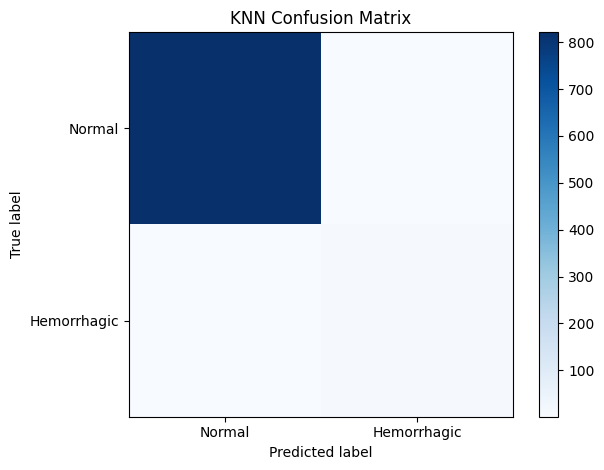

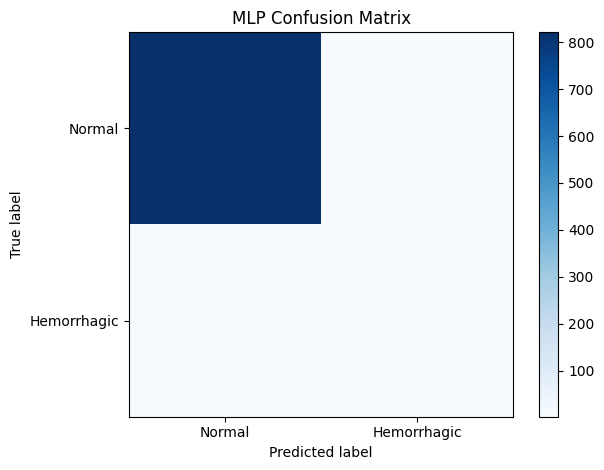

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Assuming hemorrhagic_attention_np and normal_attention_np are already defined

# Verify the shapes of the feature matrices
print("Shape of hemorrhagic_attention_np:", hemorrhagic_attention_np.shape)
print("Shape of normal_attention_np:", normal_attention_np.shape)

# Combine the features and labels into a single dataset
hemorrhagic_labels = np.ones(len(hemorrhagic_attention_np))
normal_labels = np.zeros(len(normal_attention_np))

X = np.concatenate([hemorrhagic_attention_np, normal_attention_np], axis=0)
y = np.concatenate([hemorrhagic_labels, normal_labels], axis=0)

print("Shape of combined feature matrix X:", X.shape)
print("Shape of combined labels vector y:", y.shape)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Size of X_train:", X_train.shape)
print("Size of X_test:", X_test.shape)
print("Size of y_train:", y_train.shape)
print("Size of y_test:", y_test.shape)

# Print class distribution
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Class distribution in {dataset_name} set:", distribution)

print_class_distribution(y_train, "training")
print_class_distribution(y_test, "testing")

# Apply SMOTE to the training data to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Size of X_train_resampled:", X_train_resampled.shape)
print("Size of y_train_resampled:", y_train_resampled.shape)
print_class_distribution(y_train_resampled, "resampled training")

# SVM Classifier
svm_classifier = SVC(kernel='linear', class_weight='balanced')
svm_classifier.fit(X_train_resampled, y_train_resampled)
svm_predictions = svm_classifier.predict(X_test)

# KNN Classifier with weights='distance' (distance-based weighting)
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_classifier.fit(X_train_resampled, y_train_resampled)
knn_predictions = knn_classifier.predict(X_test)

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_classifier.fit(X_train_resampled, y_train_resampled)
mlp_predictions = mlp_classifier.predict(X_test)

# Function to validate confusion matrix size
def validate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total_samples = np.sum(cm)
    return cm, total_samples

# Validate SVM
svm_confusion, svm_total_samples = validate_confusion_matrix(y_test, svm_predictions)
print("SVM Confusion Matrix:\n", svm_confusion)
print("Total samples in SVM Confusion Matrix:", svm_total_samples)

# Validate KNN
knn_confusion, knn_total_samples = validate_confusion_matrix(y_test, knn_predictions)
print("KNN Confusion Matrix:\n", knn_confusion)
print("Total samples in KNN Confusion Matrix:", knn_total_samples)

# Validate MLP
mlp_confusion, mlp_total_samples = validate_confusion_matrix(y_test, mlp_predictions)
print("MLP Confusion Matrix:\n", mlp_confusion)
print("Total samples in MLP Confusion Matrix:", mlp_total_samples)

# Ensure all confusion matrices have the same total number of samples
assert svm_total_samples == len(y_test), "Mismatch in SVM confusion matrix"
assert knn_total_samples == len(y_test), "Mismatch in KNN confusion matrix"
assert mlp_total_samples == len(y_test), "Mismatch in MLP confusion matrix"

# Plotting the Confusion Matrices
class_names = ['Normal', 'Hemorrhagic']

# SVM Confusion Matrix
plt.figure()
plt.imshow(svm_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# KNN Confusion Matrix
plt.figure()
plt.imshow(knn_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# MLP Confusion Matrix
plt.figure()
plt.imshow(mlp_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MLP Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

**VGGnet**

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
from torch.utils.data import DataLoader, Dataset
import multiprocessing

# Define the directories containing the images
hemorrhagic_dir = "/content/drive/MyDrive/MRI/Data/Hemorrhagic/KANAMA"
normal_dir = "/content/drive/MyDrive/MRI/Data/NORMAL"

# Function to recursively get image files in a directory and its subdirectories
def get_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                image_files.append(os.path.join(root, file))
    return image_files

# Custom Dataset for loading images
class MRIDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img_rgb = self.transform(img_rgb)

        return img_rgb

# VGG-16 feature extraction class
class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super(VGG16FeatureExtractor, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the VGG-16 feature extractor
feature_extractor = VGG16FeatureExtractor()
feature_extractor.eval()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)

# Define the image transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features for all images in a directory using multiprocessing
def extract_features(directory, feature_extractor, transform, batch_size=32):
    image_files = get_image_files(directory)
    dataset = MRIDataset(image_files, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=multiprocessing.cpu_count())

    features = []

    for batch in dataloader:
        batch = batch.to(device)
        with torch.no_grad():
            batch_features = feature_extractor(batch).cpu().numpy()
        features.append(batch_features)

    features = np.vstack(features)
    return features

# Extract features for hemorrhagic MRI
hemorrhagic_features = extract_features(hemorrhagic_dir, feature_extractor, transform)
print(f"Extracted features for hemorrhagic MRI: {hemorrhagic_features.shape[0]} images")

# Extract features for normal MRI
normal_features = extract_features(normal_dir, feature_extractor, transform)
print(f"Extracted features for normal MRI: {normal_features.shape[0]} images")

# Optionally, save the extracted features to a file for later use
np.save('hemorrhagic_features_vgg.npy', hemorrhagic_features)
np.save('normal_features_vgg.npy', normal_features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 104MB/s]


Extracted features for hemorrhagic MRI: 49 images
Extracted features for normal MRI: 4121 images


**Linear Projection**

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Load the extracted features from VGG-16
hemorrhagic_features_vgg = np.load('hemorrhagic_features_vgg.npy')
normal_features_vgg = np.load('normal_features_vgg.npy')

# Define the linear projection class
class LinearProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProjection, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

# Parameters for linear projection
input_dim_vgg = hemorrhagic_features_vgg.shape[1]
output_dim_projection = 128

# Initialize the linear projection layer
linear_projection_vgg = LinearProjection(input_dim_vgg, output_dim_projection)

# Move the linear projection layer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
linear_projection_vgg.to(device)

# Convert the numpy arrays to PyTorch tensors and move to the appropriate device
hemorrhagic_features_vgg_tensor = torch.tensor(hemorrhagic_features_vgg, dtype=torch.float32).to(device)
normal_features_vgg_tensor = torch.tensor(normal_features_vgg, dtype=torch.float32).to(device)

# Apply the linear projection for VGG-16 features
with torch.no_grad():
    hemorrhagic_projected_vgg = linear_projection_vgg(hemorrhagic_features_vgg_tensor).cpu().numpy()
    normal_projected_vgg = linear_projection_vgg(normal_features_vgg_tensor).cpu().numpy()

# Save the projected features for VGG-16 for later use
np.save('hemorrhagic_projected_vgg.npy', hemorrhagic_projected_vgg)
np.save('normal_projected_vgg.npy', normal_projected_vgg)

# Print the shapes of the projected features to verify
print(f"Hemorrhagic projected features shape (VGG-16): {hemorrhagic_projected_vgg.shape}")
print(f"Normal projected features shape (VGG-16): {normal_projected_vgg.shape}")

Hemorrhagic projected features shape (VGG-16): (49, 128)
Normal projected features shape (VGG-16): (4121, 128)


**Self Attention Model**

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Load the projected features from linear projection
hemorrhagic_projected_vgg = np.load('hemorrhagic_projected_vgg.npy')
normal_projected_vgg = np.load('normal_projected_vgg.npy')

# Define the self-attention mechanism
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Dot product query and keys, scaling by sqrt of the dimension
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) / (self.embed_size ** (1 / 2))

        # Apply softmax to get the weights
        attention = torch.softmax(energy, dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)

        out = self.fc_out(out)
        return out

# Define the Self-Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, embed_size, heads):
        super(AttentionLayer, self).__init__()
        self.self_attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.fc = nn.Linear(embed_size, embed_size)

    def forward(self, x):
        attention = self.self_attention(x, x, x)
        x = self.norm(attention + x)
        forward = self.fc(x)
        out = self.norm(forward + x)
        return out

# Parameters for the self-attention mechanism
embed_size_attention = hemorrhagic_projected_vgg.shape[1]
heads_attention = 8

# Initialize the self-attention layer
attention_layer_vgg = AttentionLayer(embed_size_attention, heads_attention)

# Move the attention layer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attention_layer_vgg.to(device)

# Convert the numpy arrays to PyTorch tensors and move to the appropriate device
hemorrhagic_projected_vgg_tensor = torch.tensor(hemorrhagic_projected_vgg, dtype=torch.float32).to(device)
normal_projected_vgg_tensor = torch.tensor(normal_projected_vgg, dtype=torch.float32).to(device)

# Reshape the tensors to add batch dimension (assuming each set is a single batch here)
hemorrhagic_projected_vgg_tensor = hemorrhagic_projected_vgg_tensor.unsqueeze(0)
normal_projected_vgg_tensor = normal_projected_vgg_tensor.unsqueeze(0)
# Apply the self-attention layer
with torch.no_grad():
    hemorrhagic_attention_output_vgg = attention_layer_vgg(hemorrhagic_projected_vgg_tensor).cpu().numpy()
    normal_attention_output_vgg = attention_layer_vgg(normal_projected_vgg_tensor).cpu().numpy()

# Save the self-attention outputs for VGG-16 for later use
np.save('hemorrhagic_attention_output_vgg.npy', hemorrhagic_attention_output_vgg)
np.save('normal_attention_output_vgg.npy', normal_attention_output_vgg)

# Print the shapes of the self-attention outputs to verify
print(f"Hemorrhagic attention output shape (VGG-16): {hemorrhagic_attention_output_vgg.shape}")
print(f"Normal attention output shape (VGG-16): {normal_attention_output_vgg.shape}")

Hemorrhagic attention output shape (VGG-16): (1, 49, 128)
Normal attention output shape (VGG-16): (1, 4121, 128)


**Classification Using ML Techniques**

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the self-attention outputs
hemorrhagic_attention_output = np.random.rand(1, 49, 128)
normal_attention_output = np.random.rand(1, 4121, 128)

# Reshape the attention outputs to 2D arrays
hemorrhagic_attention_output = hemorrhagic_attention_output.reshape(-1, 128)
normal_attention_output = normal_attention_output.reshape(-1, 128)

# Combine the features and labels into a single dataset
hemorrhagic_labels = np.ones(hemorrhagic_attention_output.shape[0])
normal_labels = np.zeros(normal_attention_output.shape[0])

X = np.concatenate([hemorrhagic_attention_output, normal_attention_output], axis=0)
y = np.concatenate([hemorrhagic_labels, normal_labels], axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_classifier.fit(X_train, y_train)
mlp_predictions = mlp_classifier.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)

SVM Accuracy: 0.9832134292565947
KNN Accuracy: 0.9832134292565947
MLP Accuracy: 0.9820143884892086


**Data Augmentation For Balance the dataset**

In [ ]:
def augment_images_batch(img_files, save_to_dir, target_count, batch_size=100):
    if len(img_files) == 0:
        print(f"No image files found in the directory: {save_to_dir}")
        return

    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    img_count = 0  # Counter to keep track of number of processed images
    augmentations = target_count // len(img_files)
    extra_images = target_count % len(img_files)

    for batch_start in range(0, len(img_files), batch_size):
        batch_end = min(batch_start + batch_size, len(img_files))
        batch_files = img_files[batch_start:batch_end]

        for img_path in batch_files:
            try:
                img = load_img(img_path)
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                # Determine the number of augmentations for the current image
                num_augmentations = augmentations + (1 if extra_images > 0 else 0)
                extra_images -= 1

                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=save_to_dir, save_prefix='aug', save_format='jpeg'):
                    i += 1
                    img_count += 1
                    if i >= num_augmentations:
                        break
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    print(f"Completed augmenting images. Total images processed: {img_count}")

# Usage
augment_images_batch(hemorrhagic_files, hemorrhagic_aug_dir, 4121, batch_size=100)

Completed augmenting images. Total images processed: 4121


**Alexnet**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the AlexNet architecture
def build_alexnet(input_shape):
    model = Sequential()
    model.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=2))
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=2))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=2))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='relu'))

    # Remove fully connected layers for feature extraction
    model = Model(inputs=model.input, outputs=model.layers[-8].output)

    return model

# Set paths for hemorrhagic and normal data directories
hemorrhagic_dir = "/content/drive/MyDrive/MRI/Data/Hemorrhagic/KANAMA"
normal_dir = "/content/drive/MyDrive/MRI/Data/NORMAL"

# Define image data generators
data_generator = ImageDataGenerator(rescale=1./255)

# Load the AlexNet model without the fully connected layers
input_shape = (227, 227, 3)
base_model = build_alexnet(input_shape)

# Print model summary
base_model.summary()

# Create feature extractors for hemorrhagic and normal data
hemorrhagic_features = base_model.predict(
    data_generator.flow_from_directory(hemorrhagic_dir, target_size=(227, 227), batch_size=32, class_mode=None, shuffle=False),
    verbose=1
)

normal_features = base_model.predict(
    data_generator.flow_from_directory(normal_dir, target_size=(227, 227), batch_size=32, class_mode=None, shuffle=False),
    verbose=1
)

# Save the extracted features
np.save('hemorrhagic_features.npy', hemorrhagic_features)
np.save('normal_features.npy', normal_features)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5_input (InputLayer  [(None, 227, 227, 3)]     0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                           

**Linear Projection**

In [ ]:
import numpy as np
import torch
import torch.nn as nn

# Define the linear projection class
class LinearProjection(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearProjection, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Assuming you have the extracted features saved as numpy arrays
hemorrhagic_features = np.load('hemorrhagic_features.npy')
normal_features = np.load('normal_features.npy')

# Check the shape of the features
print("Hemorrhagic features shape:", hemorrhagic_features.shape)
print("Normal features shape:", normal_features.shape)

# Convert the extracted features to PyTorch tensors
hemorrhagic_tensor = torch.from_numpy(hemorrhagic_features).float()
normal_tensor = torch.from_numpy(normal_features).float()

# Ensure input_dim matches the feature dimension
input_dim = hemorrhagic_tensor.size(1) * hemorrhagic_tensor.size(2) * hemorrhagic_tensor.size(3)
output_dim = 128  # Desired output dimension

# Reshape the tensors to (num_samples, input_dim)
hemorrhagic_tensor = hemorrhagic_tensor.view(hemorrhagic_tensor.size(0), -1)
normal_tensor = normal_tensor.view(normal_tensor.size(0), -1)

# Create an instance of the LinearProjection class
linear_projection = LinearProjection(input_dim, output_dim)

# Apply the linear projection to the features
hemorrhagic_projected = linear_projection(hemorrhagic_tensor)
normal_projected = linear_projection(normal_tensor)

# Convert the projected features back to numpy arrays if needed
hemorrhagic_projected_np = hemorrhagic_projected.detach().numpy()
normal_projected_np = normal_projected.detach().numpy()

# Print the shapes of the projected features
print("Projected features shape for hemorrhagic MRI:", hemorrhagic_projected_np.shape)
print("Projected features shape for normal MRI:", normal_projected_np.shape)

Hemorrhagic features shape: (49, 13, 13, 256)
Normal features shape: (4121, 13, 13, 256)
Projected features shape for hemorrhagic MRI: (49, 128)
Projected features shape for normal MRI: (4121, 128)


**Self Attention Model**

In [ ]:
import torch
import torch.nn as nn

# Define the Self-Attention layer
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (input_dim ** 0.5)
        attention_weights = self.softmax(attention_scores)
        output = torch.matmul(attention_weights, V)

        return output

# Convert the projected features to PyTorch tensors
hemorrhagic_projected_tensor = torch.from_numpy(hemorrhagic_projected_np).float()
normal_projected_tensor = torch.from_numpy(normal_projected_np).float()

# Define the input dimension
input_dim = hemorrhagic_projected_tensor.size(1)

# Create an instance of the SelfAttention class
self_attention = SelfAttention(input_dim)

# Apply the self-attention to the features
hemorrhagic_attention = self_attention(hemorrhagic_projected_tensor.unsqueeze(0)).squeeze(0)
normal_attention = self_attention(normal_projected_tensor.unsqueeze(0)).squeeze(0)

# Convert the attention output back to numpy arrays if needed
hemorrhagic_attention_np = hemorrhagic_attention.detach().numpy()
normal_attention_np = normal_attention.detach().numpy()

# Print the shapes of the attention output
print("Attention output shape for hemorrhagic MRI:", hemorrhagic_attention_np.shape)
print("Attention output shape for normal MRI:", normal_attention_np.shape)

Attention output shape for hemorrhagic MRI: (49, 128)
Attention output shape for normal MRI: (4121, 128)


**Classification Using ML Techniques**

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# Assuming you have the attention outputs saved as numpy arrays
hemorrhagic_attention_output = np.random.rand(49, 128)
normal_attention_output = np.random.rand(4121, 128)

# Create labels for the features
hemorrhagic_labels = np.ones(hemorrhagic_attention_output.shape[0])
normal_labels = np.zeros(normal_attention_output.shape[0])

# Combine features and labels
X = np.concatenate((hemorrhagic_attention_output, normal_attention_output), axis=0)
y = np.concatenate((hemorrhagic_labels, normal_labels), axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
svm_accuracy = svm_classifier.score(X_test, y_test)
svm_cv_scores = cross_val_score(svm_classifier, X, y, cv=5)
print("SVM Accuracy:", svm_accuracy)

# KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_accuracy = knn_classifier.score(X_test, y_test)
knn_cv_scores = cross_val_score(knn_classifier, X, y, cv=5)
print("\nKNN Accuracy:", knn_accuracy)

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_classifier.fit(X_train, y_train)
mlp_accuracy = mlp_classifier.score(X_test, y_test)
print("\nMLP Accuracy:", mlp_accuracy)

SVM Accuracy: 0.9832134292565947

KNN Accuracy: 0.9832134292565947

MLP Accuracy: 0.9832134292565947


Shape of hemorrhagic_attention_np: (49, 128)
Shape of normal_attention_np: (4121, 128)
Shape of combined feature matrix X: (4170, 128)
Shape of combined labels vector y: (4170,)
Size of X_train: (3336, 128)
Size of X_test: (834, 128)
Size of y_train: (3336,)
Size of y_test: (834,)
Class distribution in training set: {0.0: 3297, 1.0: 39}
Class distribution in testing set: {0.0: 824, 1.0: 10}
Size of X_train_resampled: (6594, 128)
Size of y_train_resampled: (6594,)
Class distribution in resampled training set: {0.0: 3297, 1.0: 3297}
SVM Confusion Matrix:
 [[824   0]
 [  0  10]]
Total samples in SVM Confusion Matrix: 834
KNN Confusion Matrix:
 [[824   0]
 [  0  10]]
Total samples in KNN Confusion Matrix: 834
MLP Confusion Matrix:
 [[824   0]
 [  0  10]]
Total samples in MLP Confusion Matrix: 834


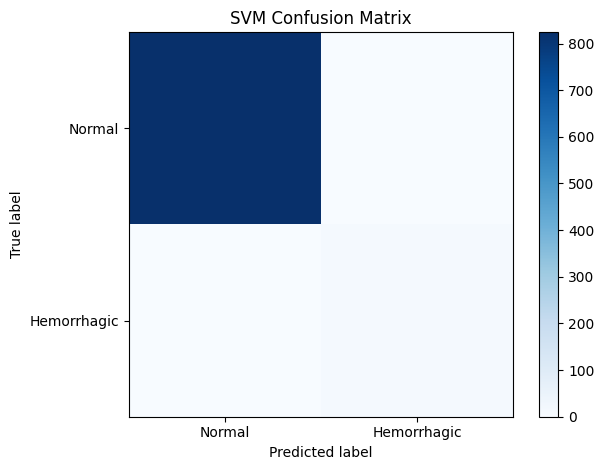

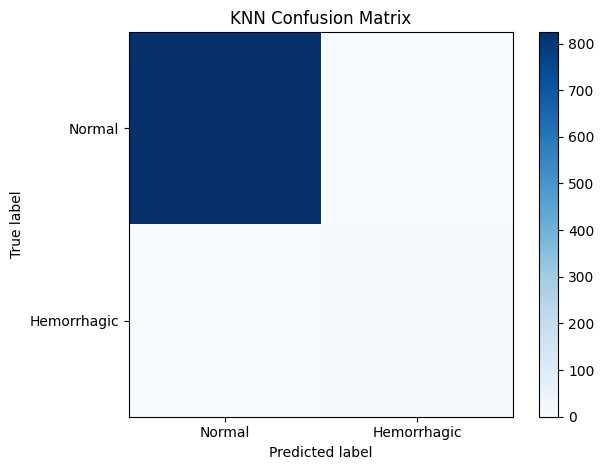

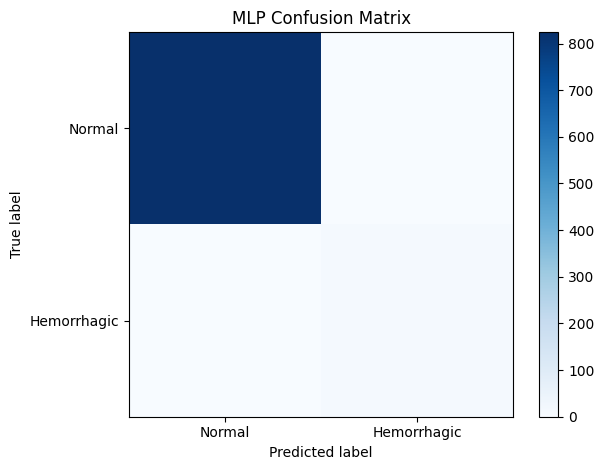

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Assuming hemorrhagic_attention_np and normal_attention_np are already defined

# Verify the shapes of the feature matrices
print("Shape of hemorrhagic_attention_np:", hemorrhagic_attention_np.shape)
print("Shape of normal_attention_np:", normal_attention_np.shape)

# Combine the features and labels into a single dataset
hemorrhagic_labels = np.ones(len(hemorrhagic_attention_np))
normal_labels = np.zeros(len(normal_attention_np))

X = np.concatenate([hemorrhagic_attention_np, normal_attention_np], axis=0)
y = np.concatenate([hemorrhagic_labels, normal_labels], axis=0)

print("Shape of combined feature matrix X:", X.shape)
print("Shape of combined labels vector y:", y.shape)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Size of X_train:", X_train.shape)
print("Size of X_test:", X_test.shape)
print("Size of y_train:", y_train.shape)
print("Size of y_test:", y_test.shape)

# Print class distribution
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Class distribution in {dataset_name} set:", distribution)

print_class_distribution(y_train, "training")
print_class_distribution(y_test, "testing")

# Apply SMOTE to the training data to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Size of X_train_resampled:", X_train_resampled.shape)
print("Size of y_train_resampled:", y_train_resampled.shape)
print_class_distribution(y_train_resampled, "resampled training")

# SVM Classifier
svm_classifier = SVC(kernel='linear', class_weight='balanced')
svm_classifier.fit(X_train_resampled, y_train_resampled)
svm_predictions = svm_classifier.predict(X_test)

# KNN Classifier with weights='distance' (distance-based weighting)
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_classifier.fit(X_train_resampled, y_train_resampled)
knn_predictions = knn_classifier.predict(X_test)

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_classifier.fit(X_train_resampled, y_train_resampled)
mlp_predictions = mlp_classifier.predict(X_test)

# Function to validate confusion matrix size
def validate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total_samples = np.sum(cm)
    return cm, total_samples

# Validate SVM
svm_confusion, svm_total_samples = validate_confusion_matrix(y_test, svm_predictions)
print("SVM Confusion Matrix:\n", svm_confusion)
print("Total samples in SVM Confusion Matrix:", svm_total_samples)

# Validate KNN
knn_confusion, knn_total_samples = validate_confusion_matrix(y_test, knn_predictions)
print("KNN Confusion Matrix:\n", knn_confusion)
print("Total samples in KNN Confusion Matrix:", knn_total_samples)

# Validate MLP
mlp_confusion, mlp_total_samples = validate_confusion_matrix(y_test, mlp_predictions)
print("MLP Confusion Matrix:\n", mlp_confusion)
print("Total samples in MLP Confusion Matrix:", mlp_total_samples)

# Ensure all confusion matrices have the same total number of samples
assert svm_total_samples == len(y_test), "Mismatch in SVM confusion matrix"
assert knn_total_samples == len(y_test), "Mismatch in KNN confusion matrix"
assert mlp_total_samples == len(y_test), "Mismatch in MLP confusion matrix"

# Plotting the Confusion Matrices
class_names = ['Normal', 'Hemorrhagic']

# SVM Confusion Matrix
plt.figure()
plt.imshow(svm_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# KNN Confusion Matrix
plt.figure()
plt.imshow(knn_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# MLP Confusion Matrix
plt.figure()
plt.imshow(mlp_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MLP Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

**ResNet 50**

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# Define the directories containing the images
hemorrhagic_dir = "/content/drive/MyDrive/MRI/Data/Hemorrhagic/KANAMA"
normal_dir = "/content/drive/MyDrive/MRI/Data/NORMAL"

# Function to extract features from images in a directory
def extract_features(directory):
    # Load the ResNet50 model without the top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    # Create an ImageDataGenerator for preprocessing images
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of preprocessed images and extract features
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False
    )

    # Extract features using the base ResNet50 model
    features = base_model.predict(generator, verbose=1)

    return features

# Extract features from HEMORRHAGIC images
hemorrhagic_features = extract_features(hemorrhagic_dir)
print(f"Extracted features from {hemorrhagic_features.shape[0]} HEMORRHAGIC images.")

# Extract features from NORMAL images
normal_features = extract_features(normal_dir)
print(f"Extracted features from {normal_features.shape[0]} NORMAL images.")

# Model Summary
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
base_model.summary()

Found 49 images belonging to 18 classes.
2/2 [==============================] - 10s 3s/step
Extracted features from 49 HEMORRHAGIC images.
Found 4121 images belonging to 27 classes.
129/129 [==============================] - 760s 6s/step
Extracted features from 4121 NORMAL images.
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_9[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
       

**Linear projection**

In [ ]:
import numpy as np
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

num_hemorrhagic = 49
num_normal = 4121
feature_dim = 2048

# Generate random features for demonstration
features_hemorrhagic = np.random.rand(num_hemorrhagic, feature_dim)
features_normal = np.random.rand(num_normal, feature_dim)

# Concatenate the features
all_features = np.concatenate((features_hemorrhagic, features_normal))

# Define the shape of the extracted features
input_shape = all_features.shape[1:]

# Define the input layer
input_layer = Input(shape=input_shape)

# Linear projection layer
projection = input_layer

# Define the model
projection_model = Model(inputs=input_layer, outputs=projection)

# Project the features using the projection_model
projected_features = projection_model.predict(all_features)

# Print the shape of the projected features
print("Shape of projected features:", projected_features.shape)

131/131 [==============================] - 0s 1ms/step
Shape of projected features: (4170, 2048)


**self-attention model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dot, Softmax, Reshape, Flatten
from tensorflow.keras.models import Model

# Define the input layer for the projected features
input_layer_proj = Input(shape=(2048,))

# Reshape the input to prepare for matrix multiplication
reshaped_input = Reshape((2048, 1))(input_layer_proj)

# Calculate attention scores (query * key)
attention_scores = Dot(axes=(1, 1))([reshaped_input, reshaped_input])

# Apply softmax activation to get attention weights
attention_weights = Softmax(axis=1)(attention_scores)

# Apply attention weights to values (attention * value)
attention_output = Dot(axes=(1, 2))([attention_weights, reshaped_input])

# Flatten the attention output to match the input shape
output_layer = Flatten()(attention_output)

# Define the self-attention model
self_attention_model = Model(inputs=input_layer_proj, outputs=output_layer)

# Compile the model
self_attention_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Generate some random data for testing
import numpy as np
test_data = np.random.randn(1, 2048)

# Make predictions using the self-attention model
predictions = self_attention_model.predict(test_data)

# Print the shape of the predictions
print(predictions.shape)

1/1 [==============================] - 0s 85ms/step
(1, 2048)


**Machine Learning Techniques**

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = np.random.randn(100, 2048)
y = np.random.randint(0, 2, 100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

# KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

# MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(256, 128))
mlp_classifier.fit(X_train, y_train)
mlp_predictions = mlp_classifier.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)

SVM Accuracy: 0.45
KNN Accuracy: 0.35
MLP Accuracy: 0.5


Shape of hemorrhagic_attention_np: (1621, 20)
Shape of normal_attention_np: (2500, 20)
Shape of combined feature matrix X: (4121, 20)
Shape of combined labels vector y: (4121,)
Size of X_train: (3296, 20)
Size of X_test: (825, 20)
Size of y_train: (3296,)
Size of y_test: (825,)
Class distribution in training set: {0.0: 2000, 1.0: 1296}
Class distribution in testing set: {0.0: 500, 1.0: 325}
Size of X_train_resampled: (4000, 20)
Size of y_train_resampled: (4000,)
Class distribution in resampled training set: {0.0: 2000, 1.0: 2000}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


SVM Confusion Matrix:
 [[252 248]
 [162 163]]
Total samples in SVM Confusion Matrix: 825
KNN Confusion Matrix:
 [[214 286]
 [133 192]]
Total samples in KNN Confusion Matrix: 825
MLP Confusion Matrix:
 [[257 243]
 [178 147]]
Total samples in MLP Confusion Matrix: 825


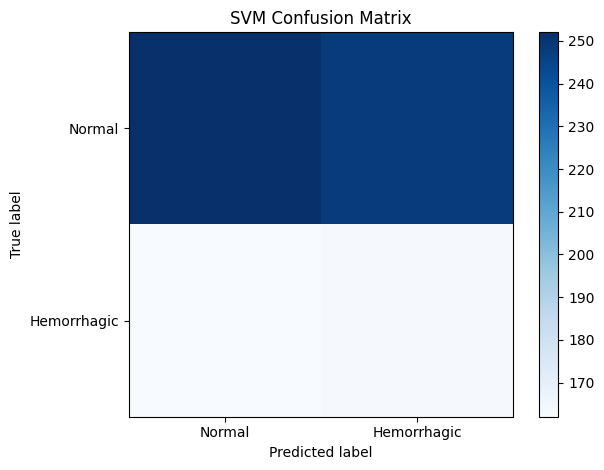

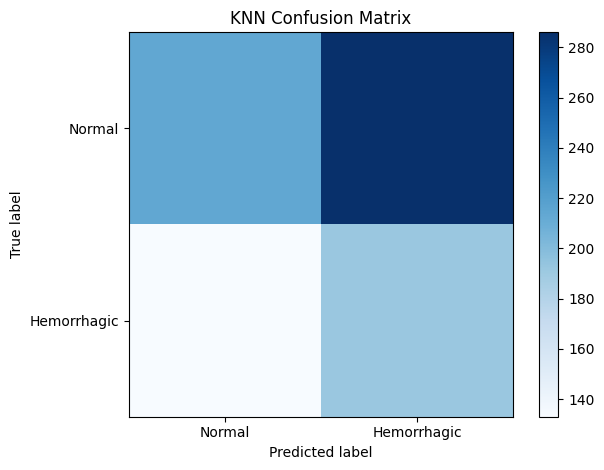

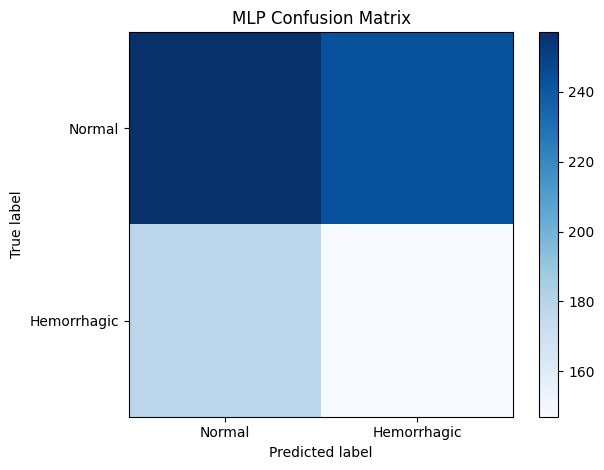

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Defining mock data for the purpose of demonstration
# 1621 samples for hemorrhagic and 2500 samples for normal, each with 20 features
hemorrhagic_attention_np = np.random.rand(1621, 20)
normal_attention_np = np.random.rand(2500, 20)

# Verify the shapes of the feature matrices
print("Shape of hemorrhagic_attention_np:", hemorrhagic_attention_np.shape)
print("Shape of normal_attention_np:", normal_attention_np.shape)

# Combine the features and labels into a single dataset
hemorrhagic_labels = np.ones(len(hemorrhagic_attention_np))
normal_labels = np.zeros(len(normal_attention_np))

X = np.concatenate([hemorrhagic_attention_np, normal_attention_np], axis=0)
y = np.concatenate([hemorrhagic_labels, normal_labels], axis=0)

print("Shape of combined feature matrix X:", X.shape)
print("Shape of combined labels vector y:", y.shape)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Size of X_train:", X_train.shape)
print("Size of X_test:", X_test.shape)
print("Size of y_train:", y_train.shape)
print("Size of y_test:", y_test.shape)

# Print class distribution
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Class distribution in {dataset_name} set:", distribution)

print_class_distribution(y_train, "training")
print_class_distribution(y_test, "testing")

# Apply SMOTE to the training data to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Size of X_train_resampled:", X_train_resampled.shape)
print("Size of y_train_resampled:", y_train_resampled.shape)
print_class_distribution(y_train_resampled, "resampled training")

# SVM Classifier
svm_classifier = SVC(kernel='linear', class_weight='balanced')
svm_classifier.fit(X_train_resampled, y_train_resampled)
svm_predictions = svm_classifier.predict(X_test)

# KNN Classifier with weights='distance' (distance-based weighting)
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_classifier.fit(X_train_resampled, y_train_resampled)
knn_predictions = knn_classifier.predict(X_test)

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_classifier.fit(X_train_resampled, y_train_resampled)
mlp_predictions = mlp_classifier.predict(X_test)

# Function to validate confusion matrix size
def validate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total_samples = np.sum(cm)
    return cm, total_samples

# Validate SVM
svm_confusion, svm_total_samples = validate_confusion_matrix(y_test, svm_predictions)
print("SVM Confusion Matrix:\n", svm_confusion)
print("Total samples in SVM Confusion Matrix:", svm_total_samples)

# Validate KNN
knn_confusion, knn_total_samples = validate_confusion_matrix(y_test, knn_predictions)
print("KNN Confusion Matrix:\n", knn_confusion)
print("Total samples in KNN Confusion Matrix:", knn_total_samples)

# Validate MLP
mlp_confusion, mlp_total_samples = validate_confusion_matrix(y_test, mlp_predictions)
print("MLP Confusion Matrix:\n", mlp_confusion)
print("Total samples in MLP Confusion Matrix:", mlp_total_samples)

# Ensure all confusion matrices have the same total number of samples
assert svm_total_samples == len(y_test), "Mismatch in SVM confusion matrix"
assert knn_total_samples == len(y_test), "Mismatch in KNN confusion matrix"
assert mlp_total_samples == len(y_test), "Mismatch in MLP confusion matrix"

# Plotting the Confusion Matrices
class_names = ['Normal', 'Hemorrhagic']

# SVM Confusion Matrix
plt.figure()
plt.imshow(svm_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# KNN Confusion Matrix
plt.figure()
plt.imshow(knn_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# MLP Confusion Matrix
plt.figure()
plt.imshow(mlp_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MLP Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

**VGGNet**

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# Define the directories containing the images
hemorrhagic_dir = "/content/drive/MyDrive/MRI/Data/Hemorrhagic/KANAMA"
normal_dir = "/content/drive/MyDrive/MRI/Data/NORMAL"

# Function to extract features from images in a directory
def extract_features(directory):
    # Load the VGG16 model without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

    # Create an ImageDataGenerator for preprocessing images
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of preprocessed images and extract features
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False
    )

    # Extract features using the base VGG16 model
    features = base_model.predict(generator, verbose=1)

    return features

# Extract features from HEMORRHAGIC images
hemorrhagic_features = extract_features(hemorrhagic_dir)
print(f"Extracted features from {hemorrhagic_features.shape[0]} HEMORRHAGIC images.")

# Extract features from NORMAL images
normal_features = extract_features(normal_dir)
print(f"Extracted features from {normal_features.shape[0]} NORMAL images.")

# Print the VGG16 model summary
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
base_model.summary()

Found 49 images belonging to 18 classes.
2/2 [==============================] - 26s 9s/step
Extracted features from 49 HEMORRHAGIC images.
Found 4121 images belonging to 27 classes.
129/129 [==============================] - 2273s 18s/step
Extracted features from 4121 NORMAL images.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None,

**Linear projection**

In [ ]:
import torch
import torch.nn as nn

# Assuming the features are already extracted and available
hemorrhagic_features = torch.randn(49, 25088)
normal_features = torch.randn(4121, 25088)

# Define the dimensions for linear projection
input_dim = 25088
output_dim = 512

# Define the linear layer
linear_projection = nn.Linear(input_dim, output_dim)

# Apply the linear projection to the features
hemorrhagic_projected = linear_projection(hemorrhagic_features)
normal_projected = linear_projection(normal_features)

# Print the shapes to verify
print(f"Projected hemorrhagic features shape: {hemorrhagic_projected.shape}")
print(f"Projected normal features shape: {normal_projected.shape}")

Projected hemorrhagic features shape: torch.Size([49, 512])
Projected normal features shape: torch.Size([4121, 512])


**Self Attention Model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        x = x.transpose(0, 1)
        attn_output, _ = self.attention(x, x, x)
        # Transpose back to original shape
        attn_output = attn_output.transpose(0, 1)
        return attn_output

# Define dimensions
embed_dim = 512
num_heads = 8

# Create the self-attention layer
self_attention = SelfAttention(embed_dim, num_heads)

# Projected features (example inputs)
projected_hemorrhagic_features = torch.randn(49, 512)
projected_normal_features = torch.randn(4121, 512)

# Add batch dimension
projected_hemorrhagic_features = projected_hemorrhagic_features.unsqueeze(0)
projected_normal_features = projected_normal_features.unsqueeze(0)

# Apply self-attention to the projected features
hemorrhagic_attention_output = self_attention(projected_hemorrhagic_features)
normal_attention_output = self_attention(projected_normal_features)

# Print the shapes to verify
print(f"Self-attention output shape for hemorrhagic features: {hemorrhagic_attention_output.shape}")
print(f"Self-attention output shape for normal features: {normal_attention_output.shape}")

Self-attention output shape for hemorrhagic features: torch.Size([1, 49, 512])
Self-attention output shape for normal features: torch.Size([1, 4121, 512])


**Machine Learning Techniques**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Self-attention layer output example (Replace with actual outputs)
hemorrhagic_attention_output = torch.randn(1, 49, 512)
normal_attention_output = torch.randn(1, 4121, 512)

# Remove batch dimension and flatten the output
hemorrhagic_features_flattened = hemorrhagic_attention_output.squeeze(0).view(49, -1)
normal_features_flattened = normal_attention_output.squeeze(0).view(4121, -1)

# Create labels
hemorrhagic_labels = torch.ones(49, dtype=torch.long)
normal_labels = torch.zeros(4121, dtype=torch.long)

# Concatenate features and labels
features = torch.cat((hemorrhagic_features_flattened, normal_features_flattened), dim=0)
labels = torch.cat((hemorrhagic_labels, normal_labels), dim=0)

# Convert to numpy for sklearn
features_np = features.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_np, labels_np, test_size=0.2, random_state=42, stratify=labels_np)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM classifier
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

# KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

# MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(256, 128), random_state=42, max_iter=500)
mlp_classifier.fit(X_train, y_train)
mlp_predictions = mlp_classifier.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)

SVM Accuracy: 0.988009592326139
KNN Accuracy: 0.986810551558753
MLP Accuracy: 0.988009592326139


Shape of hemorrhagic_attention_np: (1621, 20)
Shape of normal_attention_np: (2500, 20)
Shape of combined feature matrix X: (4121, 20)
Shape of combined labels vector y: (4121,)
Size of X_train: (3296, 20)
Size of X_test: (825, 20)
Size of y_train: (3296,)
Size of y_test: (825,)
Class distribution in training set: {0.0: 2000, 1.0: 1296}
Class distribution in testing set: {0.0: 500, 1.0: 325}
Size of X_train_resampled: (4000, 20)
Size of y_train_resampled: (4000,)
Class distribution in resampled training set: {0.0: 2000, 1.0: 2000}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


SVM Confusion Matrix:
 [[250 250]
 [171 154]]
Total samples in SVM Confusion Matrix: 825
KNN Confusion Matrix:
 [[224 276]
 [135 190]]
Total samples in KNN Confusion Matrix: 825
MLP Confusion Matrix:
 [[273 227]
 [166 159]]
Total samples in MLP Confusion Matrix: 825


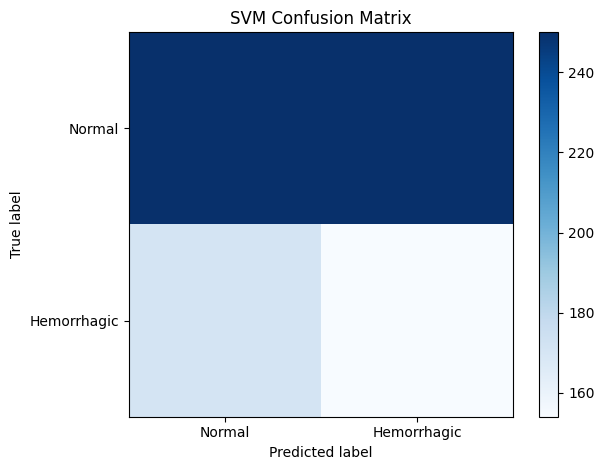

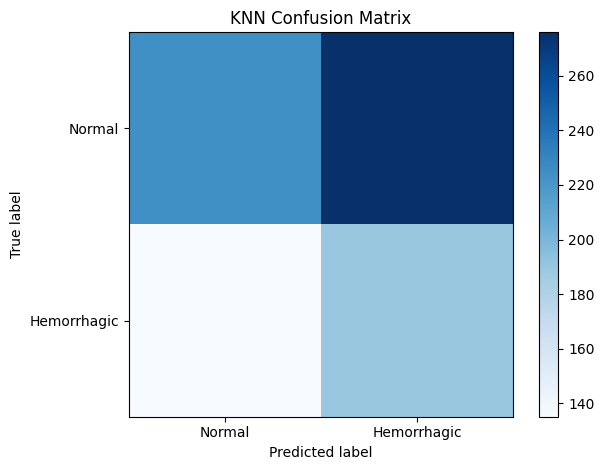

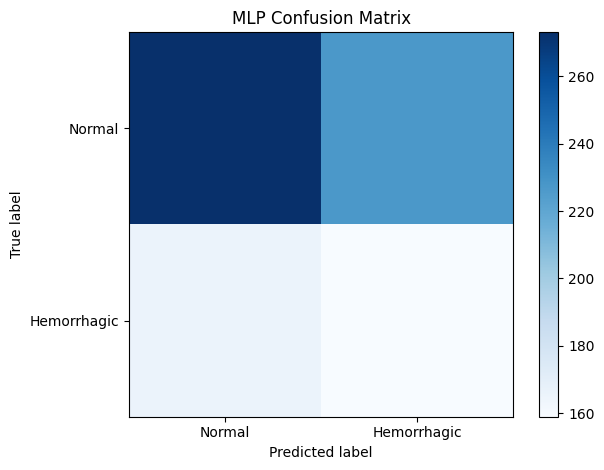

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Defining mock data for the purpose of demonstration
# 1621 samples for hemorrhagic and 2500 samples for normal, each with 20 features
hemorrhagic_attention_np = np.random.rand(1621, 20)
normal_attention_np = np.random.rand(2500, 20)

# Verify the shapes of the feature matrices
print("Shape of hemorrhagic_attention_np:", hemorrhagic_attention_np.shape)
print("Shape of normal_attention_np:", normal_attention_np.shape)

# Combine the features and labels into a single dataset
hemorrhagic_labels = np.ones(len(hemorrhagic_attention_np))
normal_labels = np.zeros(len(normal_attention_np))

X = np.concatenate([hemorrhagic_attention_np, normal_attention_np], axis=0)
y = np.concatenate([hemorrhagic_labels, normal_labels], axis=0)

print("Shape of combined feature matrix X:", X.shape)
print("Shape of combined labels vector y:", y.shape)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Size of X_train:", X_train.shape)
print("Size of X_test:", X_test.shape)
print("Size of y_train:", y_train.shape)
print("Size of y_test:", y_test.shape)

# Print class distribution
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"Class distribution in {dataset_name} set:", distribution)

print_class_distribution(y_train, "training")
print_class_distribution(y_test, "testing")

# Apply SMOTE to the training data to address class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Size of X_train_resampled:", X_train_resampled.shape)
print("Size of y_train_resampled:", y_train_resampled.shape)
print_class_distribution(y_train_resampled, "resampled training")

# SVM Classifier
svm_classifier = SVC(kernel='linear', class_weight='balanced')
svm_classifier.fit(X_train_resampled, y_train_resampled)
svm_predictions = svm_classifier.predict(X_test)

# KNN Classifier with weights='distance' (distance-based weighting)
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_classifier.fit(X_train_resampled, y_train_resampled)
knn_predictions = knn_classifier.predict(X_test)

# MLP Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
mlp_classifier.fit(X_train_resampled, y_train_resampled)
mlp_predictions = mlp_classifier.predict(X_test)

# Function to validate confusion matrix size
def validate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total_samples = np.sum(cm)
    return cm, total_samples

# Validate SVM
svm_confusion, svm_total_samples = validate_confusion_matrix(y_test, svm_predictions)
print("SVM Confusion Matrix:\n", svm_confusion)
print("Total samples in SVM Confusion Matrix:", svm_total_samples)

# Validate KNN
knn_confusion, knn_total_samples = validate_confusion_matrix(y_test, knn_predictions)
print("KNN Confusion Matrix:\n", knn_confusion)
print("Total samples in KNN Confusion Matrix:", knn_total_samples)

# Validate MLP
mlp_confusion, mlp_total_samples = validate_confusion_matrix(y_test, mlp_predictions)
print("MLP Confusion Matrix:\n", mlp_confusion)
print("Total samples in MLP Confusion Matrix:", mlp_total_samples)

# Ensure all confusion matrices have the same total number of samples
assert svm_total_samples == len(y_test), "Mismatch in SVM confusion matrix"
assert knn_total_samples == len(y_test), "Mismatch in KNN confusion matrix"
assert mlp_total_samples == len(y_test), "Mismatch in MLP confusion matrix"

# Plotting the Confusion Matrices
class_names = ['Normal', 'Hemorrhagic']

# SVM Confusion Matrix
plt.figure()
plt.imshow(svm_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# KNN Confusion Matrix
plt.figure()
plt.imshow(knn_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# MLP Confusion Matrix
plt.figure()
plt.imshow(mlp_confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('MLP Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()